In [2]:
from AZernike import *

Hello... Good morning!
Importing python packages was done.
Zernike functions are defined.



In [5]:
# cpu, gpu info
print_cpu_info()
print()
print_gpu_info()

**************************** CPU Details *****************************
Processor type: x86_64
Operating system release: 6.5.0-17-generic
Operating system version: #17-Ubuntu SMP PREEMPT_DYNAMIC Thu Jan 11 14:01:59 UTC 2024

Number of physical cores: 8
Number of logical cores: 16
Current CPU frequency: 1.23 GHz
Min CPU frequency: 1.2 GHz
Max CPU frequency: 3.5 GHz

*************************** Memory Details ***************************
Total RAM installed: 168.86 GB
Available RAM: 164.72 GB
Used RAM: 2.93 GB
RAM usage: 2.4%

**************************** GPU Details *****************************
  id  name             load    free memory    used memory    total memory    temperature
----  ---------------  ------  -------------  -------------  --------------  -------------
   0  NVIDIA TITAN Xp  0.0%    12.183 GB      0.006 GB       12.288 GB       16.0 °C
   1  NVIDIA TITAN Xp  0.0%    12.183 GB      0.006 GB       12.288 GB       21.0 °C
   2  NVIDIA TITAN Xp  0.0%    12.183 GB      0.00

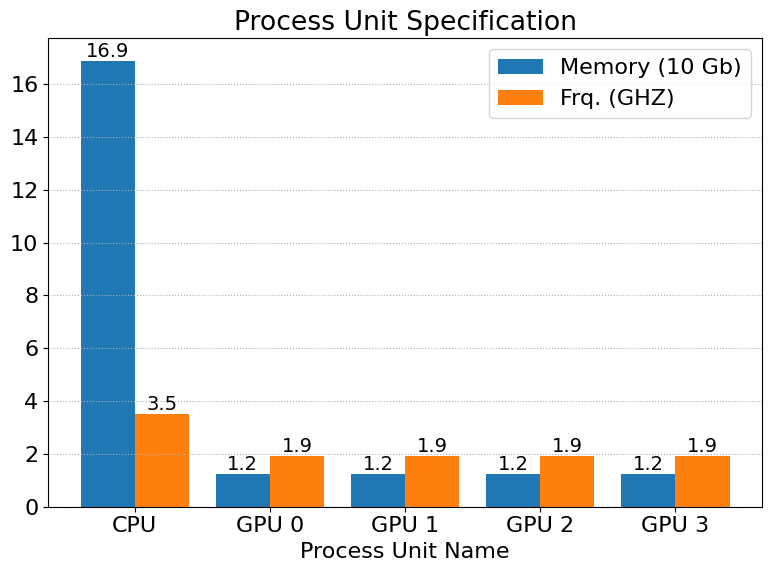

In [29]:
import psutil, igpu

devices = [ 'CPU' ]

frequencies = [ psutil.cpu_freq().max/1_000 ] 
memories = [ round(psutil.virtual_memory().total/1e9/10, 2) ]

for gpu in igpu.devices() : 
    devices.append( f"GPU {gpu.index}" )
    frequencies.append( gpu.clocks.max_graphics/1_000 )
    memories.append( gpu.memory.total/1_000/10 )
pass

fs = fontsize =16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = fontsize

row_cnt = 1; col_cnt = 1
fig, charts = plt.subplots( row_cnt, col_cnt, figsize=( 8*col_cnt, 6*row_cnt) )
charts = charts.flatten() if row_cnt*col_cnt > 1 else [charts]
chart_idx = 0 
chart = charts[ chart_idx ]

w = 0.4
n = 2
x = torch.arange(0, len(devices), dtype=torch.float64 )
x += w*((1.0 - n )/2.0)

yticks = torch.arange( 0, math.ceil( max( max(frequencies), max(memories)) ), 2 )

bar = chart.bar( x - w/2 + w*0, memories, width=w, label="Memory (10 Gb)" )
chart.bar_label( bar, fmt='%.1f', fontsize=fs-2 )
bar = chart.bar( x - w/2 + w*1, frequencies, width=w, label="Frq. (GHZ)" )
chart.bar_label( bar, fmt='%.1f', fontsize=fs-2 )

chart.set_xticks( x, devices )
chart.set_yticks( yticks )
chart.grid( axis='y', linestyle="dotted" )
chart.set_title( "Process Unit Specification" )
chart.set_xlabel( "Process Unit Name")

chart.legend()

plt.tight_layout()
plt.show()

In [8]:
from AZernike import *

print( "Plots of Radial Poolynomial" )
print_curr_time()

debug = 0

datas = []

datas.append( { "order" : (0, 0), "coeffs" : [1] })
datas.append( { "order" : (1, 1), "coeffs" : [1] })
datas.append( { "order" : (2, 0), "coeffs" : [2, -1] })
datas.append( { "order" : (2, 2), "coeffs" : [1] })

datas.append( { "order" : (3, 1), "coeffs" : [3, -2] })
datas.append( { "order" : (3, 3), "coeffs" : [1] })

datas.append( { "order" : (4, 0), "coeffs" : [6, -6, 1] })
datas.append( { "order" : (4, 2), "coeffs" : [4, -3] })
datas.append( { "order" : (4, 4), "coeffs" : [1] })

datas.append( { "order" : (5, 1), "coeffs" : [10, -12, 3] })
datas.append( { "order" : (5, 3), "coeffs" : [5, -4] })
datas.append( { "order" : (5, 5), "coeffs" : [1] })

datas.append( { "order" : (6, 0), "coeffs" : [20, -30, 12, -1] })
datas.append( { "order" : (6, 2), "coeffs" : [15, -20, 6] })
datas.append( { "order" : (6, 4), "coeffs" : [6, -5] })
#datas.append( { "order" : (6, 6), "coeffs" : [1] })

max_q = 5

fs = fontsize = 16
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = fontsize
row_cnt = max_q + 1 ; col_cnt = 1
fig, charts = plt.subplots( row_cnt, col_cnt, figsize=( 8*col_cnt, 3.9*row_cnt) )
charts = charts.flatten() if row_cnt*col_cnt > 1 else [ charts ]

use_gpu = 1
device_no = 0 
hash = {} 
device = torch.device( f"cuda:{device_no}" ) if use_gpu else torch.device( f"cpu" )

print( f"use_gpu = {use_gpu}, device_no = {device_no}" )

step = 1/40
rho = torch.arange( 0, 1 + step, step, device=device )
rho = rho[ torch.where( rho <= 1 ) ]

markers = [ ".", "o", "s", "p", "*", "D", "d" ]

for data in datas : 
    order  = data[ "order" ]
    coeffs = data[ "coeffs" ]
    
    p = order[0]
    q = order[1]
    
    r_pl_numeric = Rpq( p, q, rho, device=device, hash=hash, debug=debug )
    r_pl_analytic = torch.zeros_like( rho, device=device )

    for idx, coeff in enumerate( coeffs ) : 
        r_pl_analytic += coeff*torch.pow( rho, p - 2*idx )
    pass 

    chart = charts[q]
    chart.plot( rho.cpu(), r_pl_analytic.cpu(), linestyle="solid" )
    chart.plot( rho.cpu(), r_pl_numeric.cpu(), markers[p], label=r"$R_{" + f"{p}{q}" + "}$" )
    chart.set_xlim(  0, 1 )
    chart.set_ylim( -1.05, 1.05 )

    chart.set_title( rf"$q$ = {q}" )
    chart.set_ylabel( r"$R_{pq}$($\rho)$" )
    chart.set_xlabel( rf"$\rho$" )
    chart.legend(loc="upper center", ncol=len(coeffs) )
    chart.legend()
pass

plt.tight_layout()
plt.savefig( f"./result/zernike_01_radial_function.png" )
plt.show()

print( "Done.")

Plots of Radial Poolynomial
Current Time = 18:10:28
use_gpu = 1, device_no = 0


Current Time = 20:20:42

Zernike Radial polynomail orthogonality validation
use_gpu = 0, use_hash = 1



Resolution:   0%|          | 0/5 [00:00<?, ?it/s]


************************************************************
Radial Grid Count = 1_024, T = 40
Elapsed time = 0.29607609999993656
Error average = 0.0278055721
Memories used = 16_368 bytes

************************************************************
Radial Grid Count = 2_048, T = 40
Elapsed time = 0.3255314000000453
Error average = 0.0132417089
Memories used = 32_752 bytes

************************************************************
Radial Grid Count = 4_096, T = 40
Elapsed time = 0.5045631000000412
Error average = 0.0064391929
Memories used = 65_520 bytes

************************************************************
Radial Grid Count = 8_192, T = 40
Elapsed time = 0.6337103000000752
Error average = 0.0031751426
Memories used = 131_056 bytes

************************************************************
Radial Grid Count = 16_384, T = 40
Elapsed time = 0.9512927000000673
Error average = 0.0015844938
Memories used = 262_128 bytes

Plotting .... 


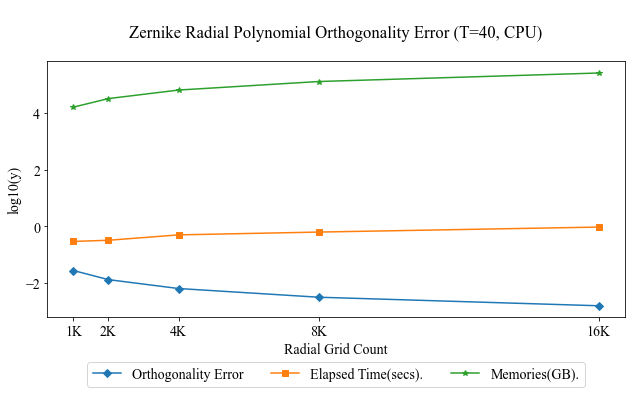

Current Time = 20:20:45
Wall time: 2.9 s


In [4]:
%%time
from IPython.display import clear_output
clear_output()

from AZernike import *

def validte_radial_polynomial( T, use_gpu, use_hash = 0, debug=0) : 
    print_curr_time()

    print()
    print( "Zernike Radial polynomail orthogonality validation" ) 
    print( f"use_gpu = {use_gpu}, use_hash = {use_hash}" )
    print()

    numpy.set_printoptions(suppress=1)

    error_avgs = []
    elapsed_list = []

    resolutions = [ 2**x for x in range( 10, 14 + 1 ) ]
    memories = []
    
    np = cupy if use_gpu else numpy
    
    for grid_count in tqdm( resolutions, desc="Resolution" ):
        then = perf_counter() 

        dr = 1.0/grid_count

        rho = np.linspace( 0, 1 + dr, grid_count )
        rho = rho[ np.where( rho <= 1 ) ]

        # debug and print( f"rho = {rho}" )

        good_cnt = 0 
        fail_cnt = 0 

        error_sum = 0
        mem_max = 0 

        hash= {}

        for p in range( 0, T + 1 ) :
            for q in range( 0, T + 1 ) :
                for l in range( -q, q + 1 ) :
                    if abs(l) > p or abs(l) > q:
                        continue ;
                    elif ( p - abs(l) )%2 == 1 :
                        continue
                    elif ( q - abs(l) )%2 == 1 :
                        continue
                    pass

                    r_pl = Rpq( p, l, rho, use_gpu=use_gpu, hash=hash, use_hash=use_hash, debug=0 )
                    r_ql = Rpq( q, l, rho, use_gpu=use_gpu, hash=hash, use_hash=use_hash, debug=0 )
                    
                    mem = (r_pl.nbytes + r_ql.nbytes)
                    
                    if mem > mem_max :
                        mem_max = mem

                    sum = 0 
                    sum = np.sum(r_pl*r_ql*rho*dr)*2*(p + 1)

                    expect = [0, 1][ p == q ]
                    error = abs(expect -sum)
                    error_sum += error
                    success = error < 1/1_000 
                    success_t = 'Good' if success else 'Fail'

                    good_cnt += success
                    fail_cnt += (not success)

                    #debug and print( f"[{p:02d}][{q:02d}] {success_t} : Rpl({p}, {l:2d})*Rql({q}, {l:2d}) = {sum}, exptect = {expect}", flush="True" )
                pass
            pass
        pass

        del hash

        error_avg = error_sum/(good_cnt + fail_cnt)
        error_avgs.append( error_avg )
        memories.append( mem_max )

        elapsed = perf_counter() - then
        elapsed_list.append( elapsed )

        if debug : 
            print( line2 )
            print( f"Radial Grid Count = {grid_count:_}, T = {T}" )
            print( f"Elapsed time = { elapsed }" )
            print( f"Error average = {error_avg:.10f}" )
            #print( f"Fail count = {fail_cnt}, Good count = {good_cnt}", flush="True" )
            print( f"Memories used = {mem_max:_} bytes" )
        pass
    pass

    print( "\nPlotting .... ", flush="True" )

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "14"

    row_cnt = 1; col_cnt = 1
    fig, charts = plt.subplots( row_cnt, col_cnt, figsize=( 9*col_cnt, 6*row_cnt) )
    charts = charts.flatten() if row_cnt*col_cnt > 1 else [charts]
    chart_idx = 0 
    chart = charts[ chart_idx ]

    resolutions = np.array( resolutions )
    error_avgs = np.log10( np.array( error_avgs ) ) 
    elapsed_list = np.log10( np.array( elapsed_list ) )
    memories = np.log10( np.array( memories ) )

    if use_gpu :
        resolutions = cupy.asnumpy( resolutions )
        error_avgs = cupy.asnumpy( error_avgs )
        elapsed_list = cupy.asnumpy( elapsed_list )
        memories = cupy.asnumpy( memories )
    pass

    chart.plot( resolutions, error_avgs, marker="D", label="Orthogonality Error" )
    chart.plot( resolutions, elapsed_list, marker="s", label="Elapsed Time(secs)." )
    chart.plot( resolutions, memories, marker="*", label="Memories(GB)." )

    device = "GPU" if use_gpu else "CPU"
    
    chart.set_title( f"\nZernike Radial Polynomial Orthogonality Error (T={T}, {device})\n" )
    chart.set_xlabel( "Radial Grid Count\n\n" )
    chart.set_ylabel( "log10(y)" )
    chart.set_xticks( resolutions )
    chart.set_xticklabels( [ f"{x/1_000:1.0f}K" for x in resolutions ] ) 
    chart.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=3)

    plt.tight_layout();
    plt.savefig( f"./result/zernike_02_radial_orthogonality.png" )
    plt.show()

    print_curr_time()
pass # -- validte_radial_polynomial

T = 40 #6 #10 # 20
use_gpu = 0 
use_hash = 1
validte_radial_polynomial( T, use_gpu=use_gpu, use_hash=use_hash, debug=1 )


Current Time = 20:04:57

Zernike polynomail orthogonality validation
use_gpu = 1, use_hash = 1



K:   0%|          | 0/10 [00:00<?, ?it/s]


************************************************************
K = 0.5, Resolution = 500, T = 5
Elapsed time = 2.859431699999959
Error avg. = 0.0004223394

************************************************************
K = 1.0, Resolution = 1_000, T = 5
Elapsed time = 9.097620800000072
Error avg. = 0.0001887721

************************************************************
K = 1.5, Resolution = 1_500, T = 5
Elapsed time = 14.312725800000067
Error avg. = 0.0001056537

************************************************************
K = 2.0, Resolution = 2_000, T = 5
Elapsed time = 16.481055000000197
Error avg. = 0.0000744328

************************************************************
K = 2.5, Resolution = 2_500, T = 5
Elapsed time = 25.265369299999975
Error avg. = 0.0000523565

************************************************************
K = 3.0, Resolution = 3_000, T = 5
Elapsed time = 24.893459099999973
Error avg. = 0.0000496961

************************************************************


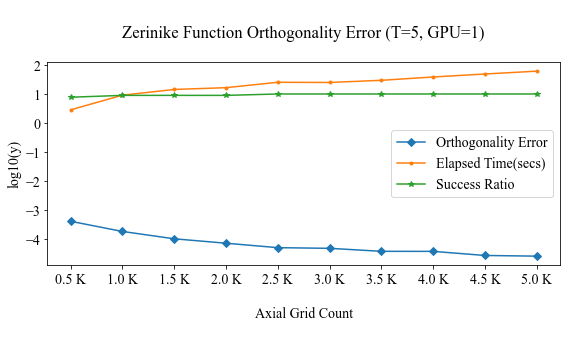

Wall time: 4min 30s


In [2]:
%%time

from IPython.display import clear_output
clear_output()

# 저니크 함수 테스트 

from AZernike import *

print_curr_time()

print( "\nZernike polynomail orthogonality validation" )

def test_zernike_function_orthogonality( T, Ks, use_gpu, use_hash=0, debug = 0 ) : 
    print( f"use_gpu = {use_gpu}, use_hash = {use_hash}" )
    print()

    success_ratios = []
    error_avgs = []
    elapsed_list = []

    #resolutions = [ 2**x for x in range( 10, 15 + 1 ) ]
    #resolutions = [ x for x in range( 800, 1_700, 200 ) ]
    #resolutions = [ 2**x for x in range( 8, 11 + 1 ) ]

    for K in tqdm( Ks, desc="K" ) :
        resolution = int( 1_000*K )

        if 1 or debug : 
            print( line2 )
            print( f"K = {K}, Resolution = {resolution:_}, T = {T}" )
        pass
        
        then = perf_counter() 

        h = resolution
        w = h 
        img = numpy.ones( (h, w), numpy.uint8 )
        
        if use_gpu :
            img = cupy.asarray( img )
        pass
        
        rho, theta, x, y, dx, dy, k, area = rho_theta( resolution, circle_type="inner", use_gpu=use_gpu, debug=debug )
        
        good_cnt = 0 
        fail_cnt = 0 

        error_sum = 0
        
        hash= {}
        
        np = cupy if use_gpu else numpy

        for p1 in range( 0, T + 1 ) :
            for q1 in range( -p1, p1 + 1, 2 ) :
                for p2 in range( 0, T +1 ) :
                    for q2 in range( -p2, p2 + 1, 2 ) : 
                        v_pl = Vpq( p1, q1, rho, theta, use_gpu=use_gpu, hash=hash, use_hash=use_hash, debug=0)
                        v_ql = Vpq( p2, q2, rho, theta, use_gpu=use_gpu, hash=hash, use_hash=use_hash, debug=0)

                        sum_arr = np.sum( np.conjugate(v_pl)*v_ql )
                        sum_integration = sum_arr*dx*dy*(p1 +1)/pi
                        sum = np.absolute( sum_integration )

                        expect = [0, 1][ p1 == p2 and q1 == q2 ]
                        error = abs(expect -sum)
                        error_sum += error
                        success = error < 1/1_000 
                        success_t = 'Good' if success else 'Fail'

                        good_cnt += success
                        fail_cnt += (not success)

                        if not use_hash :
                            del v_pl, v_ql, sum_arr, sum_integration
                        pass

                        debug and print( f"[{p1:02d}][{q1:02d}] {success_t} : V*pl({p1}, {q1:2d})*Vpl({p2}, {q2:2d}) = {sum:.4f}, exptect = {expect}, error={error:.4f}", flush=1 )
                    pass
                pass
            pass
        pass

        del hash

        success_ratio = good_cnt/(good_cnt + fail_cnt)
        success_ratios.append( success_ratio )
        error_avg = error_sum/(good_cnt + fail_cnt)
        error_avgs.append( error_avg )
        
        elapsed = perf_counter() - then
        elapsed_list.append( elapsed )

        if 1 or debug : 
            print( f"Elapsed time = { elapsed }" )
            print( f"Error avg. = {error_avg:.10f}" )
            #print( f"Success = {success_ratio*100:.2f}%, Fail count = {fail_cnt}, Good count = {good_cnt}", flush="True" )
        pass
    pass

    print( "\nPlotting .... ", flush="True" )

    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = "14"

    row_cnt = 1; col_cnt = 1
    fig, charts = plt.subplots( row_cnt, col_cnt, figsize=( 8.1*col_cnt, 5*row_cnt) )
    charts = charts.flatten() if row_cnt*col_cnt > 1 else [charts]
    chart_idx = 0 
    chart = charts[ chart_idx ]

    Ks = np.array( Ks )
    error_avgs = np.log10( np.array( error_avgs ) )
    success_ratios = np.array( success_ratios )
    elapsed_list = np.array( elapsed_list )
    elapsed_list = np.log10( elapsed_list )

    if use_gpu :
        Ks = cupy.asnumpy( Ks )
        error_avgs = cupy.asnumpy( error_avgs )
        elapsed_list = cupy.asnumpy( elapsed_list )
        success_ratios = cupy.asnumpy( success_ratios )
    pass

    chart.plot( Ks, error_avgs, marker="D", label="Orthogonality Error" )
    chart.plot( Ks, elapsed_list, marker=".", label="Elapsed Time(secs)" )
    chart.plot( Ks, success_ratios, marker="*", label="Success Ratio" )

    chart.set_title( f"\nZerinike Function Orthogonality Error (T={T}, GPU={use_gpu})\n" )
    chart.set_xlabel( "\nAxial Grid Count\n" )
    chart.set_ylabel( "log10(y)" )
    chart.set_xticks( Ks ) 
    chart.set_xticklabels( [ f"{x} K" for x in Ks ] ) 
    chart.legend()

    plt.tight_layout();
    plt.savefig( f"./result/zernike_03_function_orthogonality.png" )
    plt.show()
pass # test_zernike_function_orthogonality

T = 5 #20 #4 #5 #10 # 20 
Ks = numpy.arange( 0.5, 5.5, 0.5 )
    
use_gpu = 1
use_hash = 1
test_zernike_function_orthogonality(T, Ks, use_gpu=use_gpu, use_hash=use_hash, debug=0)
